In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
# from collections import OrderedDict
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


## 0. Mount to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Customs-Declaration-Datasets-en/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Customs-Declaration-Datasets-en/'
/content/drive/MyDrive/Customs-Declaration-Datasets-en


## 1. Load Dataset 

In [ ]:
X_train = pd.read_csv('./data_enc/encoded_train_eng.csv')
X_valid = pd.read_csv('./data_enc/encoded_valid_eng.csv')

In [ ]:
y_train= pd.read_csv('./data_enc/y_train_eng.csv')
y_valid= pd.read_csv('./data_enc/y_valid_eng.csv')

## 1_2. Load Dataset  & Reflect Feature Importance

In [ ]:
print(X_train.columns)
print(X_train.info())

Index(['Office ID', 'Process Type', 'Import Type', 'Import Use',
       'Payment Type', 'Mode of Transport', 'Declarant ID', 'Importer ID',
       'Seller ID', 'Courier ID', 'HS10 Code', 'Country of Departure',
       'Country of Origin', 'Tax Rate', 'Tax Type',
       'Country of Origin Indicator', 'Net Mass', 'Item Price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37385 entries, 0 to 37384
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Office ID                    37385 non-null  int64  
 1   Process Type                 37385 non-null  int64  
 2   Import Type                  37385 non-null  int64  
 3   Import Use                   37385 non-null  int64  
 4   Payment Type                 37385 non-null  int64  
 5   Mode of Transport            37385 non-null  int64  
 6   Declarant ID                 37385 non-null  int64  
 7   Importer ID   

In [ ]:
X_train

,Office ID,Process Type,Import Type,Import Use,Payment Type,Mode of Transport,Declarant ID,Importer ID,Seller ID,Courier ID,HS10 Code,Country of Departure,Country of Origin,Tax Rate,Tax Type,Country of Origin Indicator,Net Mass,Item Price
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.799250e-06,5.283441e-05
1,2,1,1,1,1,2,2,2,2,1,2,2,2,2,2,2,1.891212e-04,5.333071e-05
2,3,1,1,1,1,2,3,3,3,1,3,2,2,3,3,3,3.448563e-07,7.597590e-07
3,2,1,1,1,2,2,4,4,4,1,4,3,3,1,4,2,1.535693e-04,2.097236e-04
4,3,1,1,1,1,1,5,5,5,1,5,3,3,4,2,3,3.998334e-04,9.033619e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37380,2,1,1,1,2,2,129,5031,428,1,28,2,2,5,4,2,9.546022e-06,4.879585e-08
37381,3,1,4,6,2,1,329,7703,369,1,27,2,2,10,3,1,3.228655e-05,4.978624e-06
37382,2,1,1,1,1,1,337,158,1110,1,703,2,2,38,8,4,8.329863e-07,4.406955e-07
37383,3,1,1,1,1,2,110,12719,2370,1,506,11,9,1,2,3,3.415577e-04,4.422999e-05


## 2. Over sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
over_sampler = RandomOverSampler(random_state = 11)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [ ]:
# over_sampler = RandomOverSampler(random_state = 11)
# X_valid_over, y_valid_over = over_sampler.fit_resample(X_valid,y_valid)

In [ ]:
y_train_over = np.array(y_train_over).ravel()
y_valid = np.array(y_valid).ravel()

## 3. Select xgboost Parameter

In [ ]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
from scipy import stats
from scipy.stats import randint

In [ ]:
xgb = XGBClassifier()#objective=' binary:logistic',
                    #metric='binary',
                    #eval_metric='logloss',
                    #nthread=1)

# A parameter grid for XGBoost
params = {'n_estimators': stats.randint(150, 1000),
          'learning_rate': stats.uniform(0.01, 0.6),
          'min_child_weight': [1, 2, 3, 4, 5],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
        }
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=5, # you want 5 here not 25 if I understand you correctly 
                                   scoring='roc_auc',
                                   n_jobs=1,                                   
                                   cv=skf.split(X_train_over, y_train_over),
                                   verbose=3,
                                   random_state=1001 )

# Here we go
start_time = timer(None) 
random_search.fit(X_train_over, y_train_over)
timer(start_time) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8;, score=0.911 total time=  19.9s
[CV 2/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8;, score=0.906 total time=  17.9s
[CV 3/3] END colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8;, score=0.914 total time=  22.3s
[CV 1/3] END colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6;, score=0.866 total time=  16.9s
[CV 2/3] END colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6;, score=0.862 total time=  15.5s
[CV 3/3] END colsample_bytree=0.6, gamma=5, learning_ra

In [ ]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# param_comb = 5
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('./data1/xgb-random-grid-search-results-01.csv', index=False)

## 4. Train model

In [ ]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("confusion\n", confusion)
    print("Accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=4,
              min_child_weight=2,
              n_estimators=424, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=0, objective= 'binary:logistic', eval_metric='logloss')

In [ ]:
start_time = timer(None) 
get_model_train_eval(xgb_model, ftr_train = X_train_over, ftr_test = X_valid, 
                      tgt_train = y_train_over, tgt_test = y_valid)
timer(start_time) 

confusion
 [[5445  985]
 [ 683 1021]]
Accuracy: 0.7949, precision: 0.6988, recall: 0.7230, F1:0.7088


 Time taken: 0 hours 0 minutes and 15.75 seconds.


## 5. Save model

In [ ]:
import pickle
file_name = "./model/xgb_reg_eng.pkl"
os.makedirs('./model/', exist_ok = True)

# save
pickle.dump(xgb_model, open(file_name, "wb"))

### 3.2 Predict with xgboost model

In [ ]:
file_name = "./model/xgb_reg_eng.pkl"

# load
w_xgb_model = pickle.load(open(file_name, "rb"))

In [ ]:
w_preds = w_xgb_model.predict(X_valid_over)
w_pred_proba = w_xgb_model.predict_proba(X_valid_over)[:,1]

In [ ]:
get_clf_eval(y_valid_over, w_preds, w_pred_proba)

confusion
 [[5445  985]
 [2577 3853]]
Accuracy: 0.7230, precision: 0.7376, recall: 0.7230, F1:0.7187



## 6. Feature Importance

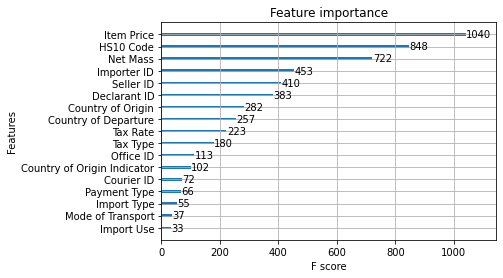

In [ ]:
%matplotlib inline
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

## 6. Compare Prediction & Ground Truth

In [ ]:
X_valid

,Office ID,Process Type,Import Type,Import Use,Payment Type,Mode of Transport,Declarant ID,Importer ID,Seller ID,Courier ID,HS10 Code,Country of Departure,Country of Origin,Tax Rate,Tax Type,Country of Origin Indicator,Net Mass,Item Price
0,2,1,1,5,1,2,609,8431,378,1,352,2,2,44,3,5,1.501374e-05,5.891449e-05
1,3,1,1,1,1,1,460,7715,10538,1,641,10,2,1,3,5,6.663890e-06,4.331731e-06
2,1,1,1,1,4,1,62,593,2143,1,951,2,2,9,3,4,5.647647e-06,3.704823e-07
3,3,1,1,1,1,2,812,4013,10539,1,217,2,2,12,2,5,4.997918e-07,3.517048e-07
4,8,1,1,1,1,2,1221,6612,4445,1,3338,6,5,48,8,3,4.997918e-08,1.222383e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8129,2,1,1,1,1,1,730,13676,764,36,419,2,2,10,3,4,1.549354e-05,7.853747e-06
8130,1,1,1,1,1,1,141,2121,6332,1,185,16,20,5,4,4,9.046231e-05,4.007561e-06
8131,3,1,9,1,1,2,69,741,141,1,630,8,20,2,2,1,1.557684e-06,6.675082e-07
8132,2,1,1,1,3,2,59,3236,4504,6,980,17,16,1,7,5,1.194502e-05,2.802593e-05


In [ ]:
pred_valid = w_xgb_model.predict(X_valid)

In [ ]:
# Get performance
a = np.array([pred_valid])
pred_df = pd.DataFrame({'Fraud_Prediction':a[0]})
pred_df

,Fraud_Prediction
0,0
1,0
2,0
3,1
4,1
...,...
8129,0
8130,0
8131,0
8132,0


In [ ]:
df_valid = pd.read_csv('./data/df_syn_valid_eng.csv')
final_df = df_valid.join(pred_df)
final_df

,Declaration ID,Date,Office ID,Process Type,Import Type,Import Use,Payment Type,Mode of Transport,Declarant ID,Importer ID,...,Country of Departure,Country of Origin,Tax Rate,Tax Type,Country of Origin Indicator,Net Mass,Item Price,Fraud,Critical Fraud,Fraud_Prediction
0,56839011,2021-01-01,40,B,11,11,11,40,76NV527,SHHZGSL,...,CN,CN,7.2,FCN1,E,901.2,415092.72,0,0,0
1,64859691,2021-01-01,20,B,11,21,11,10,IP2CUKX,H6W16WM,...,HK,CN,0.0,FCN1,E,400.0,30520.00,0,0,0
2,99950077,2021-01-01,30,B,11,21,14,10,XCIAAPR,PCW8KX7,...,CN,CN,3.2,FCN1,S,339.0,2610.30,0,0,0
3,22601387,2021-01-01,20,B,11,21,11,40,WOGOUHN,92NKKFG,...,CN,CN,13.0,A,E,30.0,2478.00,0,0,1
4,33240058,2021-01-02,16,B,11,21,11,40,BROGNIT,0PSV20Q,...,US,US,1.3,CIT,B,3.0,86125.20,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8129,95650431,2021-03-31,40,B,11,21,11,10,CAJMKA7,JQXT8JI,...,CN,CN,4.8,FCN1,S,930.0,55335.00,0,0,0
8130,48093440,2021-03-31,30,B,11,21,11,10,S1N2WHR,E0QJHWB,...,KR,KR,6.5,C,S,5430.0,28236.00,0,0,0
8131,12889495,2021-03-31,20,B,86,21,11,40,LP6EWRR,WQAQ336,...,JP,KR,8.0,A,G,93.5,4703.05,0,0,0
8132,39908806,2021-03-31,40,B,11,21,18,40,PF1L1IG,AIWW1ET,...,MY,MY,0.0,FAS1,E,717.0,197461.80,0,0,0


In [ ]:
get_clf_eval(y_valid, pred_valid, None)

confusion
 [[5445  985]
 [ 683 1021]]
Accuracy: 0.7949, precision: 0.6988, recall: 0.7230, F1:0.7088



In [ ]:
final_df.to_csv('./data/predict_valid_eng.csv', index=None)

### 7. Predict on Test Data

In [ ]:
X_test = pd.read_csv('./data_enc/encoded_test_eng.csv')
y_test = pd.read_csv('./data_enc/y_test_eng.csv')

import pickle
file_name = "./model/xgb_reg_eng.pkl"

# load
xgb_model = pickle.load(open(file_name, "rb"))

pred_test = w_xgb_model.predict(X_test)
get_clf_eval(y_test, pred_test, None)

confusion
 [[5650  996]
 [ 769 1066]]
Accuracy: 0.7919, precision: 0.6986, recall: 0.7155, F1:0.7060



In [ ]:
df_test = pd.read_csv('./data/df_syn_test_eng.csv')
df_test["Fraud_Prediction"] = pred_test
df_test.to_csv('./data/predict_test_eng.csv', index=None)